# Train a shallow SNN on the Randman Dataset

In [1]:
import sys

sys.path.append("../")

import numpy as np
import torch

import matplotlib.pyplot as plt
import seaborn as sns
from spiffyplots import MultiPanel

import stork
from stork.datasets import make_coRandman, RasDataset, split_dataset
from stork.regularizers import LowerBoundL2, UpperBoundL2
from stork.models import RecurrentSpikingModel
from stork.nodes import InputGroup, ReadoutGroup, LIFGroup, DeltaSynapseLIFGroup, FilterLIFGroup
from stork.connections import Connection, SuperConnection
from stork.generators import StandardGenerator
from stork.initializers import KaimingNormalInitializer
from stork.monitors import PopulationFiringRateMonitor
from stork.optimizers import SMORMS3
from stork.loss_stacks import SumOfSoftmaxCrossEntropy
from stork.plotting import plot_activity_snapshot
import wandb

using delay stork version - filter cascades


## Generate Dataset

Specify the Dataset Parameters

In [2]:
# dataset parameters
dim_manifold = 1
nb_sub_classes = 5
nb_classes = nb_sub_classes**2
nb_inputs = 20

nb_time_steps = 180
T_delay = 30
sample_duration = 30


nb_samples = 100
nb_spikes = 1
alpha = 1
randmanseed = 1
dt = 2e-3

duration = nb_time_steps * dt


# Model Parameters
batch_size = 250
beta = 20
device = torch.device("cuda:0")
dtype = torch.float

tau_mem = 20e-3
tau_syn = 10e-3
tau_readout = 40e-3

tau_filter = 20e-3
nb_filters = 10

nb_hidden_units = int(
    np.round(
        128
        * (nb_inputs * nb_filters + nb_classes)
        / (nb_inputs + nb_classes + nb_filters)
    )
)
print(nb_hidden_units)
nb_hidden_units = 8*30
nb_groups = 8


lr = 5e-3
nb_epochs = 50

rec = False

# regularizer parameters
lowerBoundL2Strength = 100
lowerBoundL2Threshold = 1e-3
upperBoundL2Strength = 0.1
upperBoundL2Threshold = (
    4  # Regularizes spikecount: 4 spikes ~ 20 Hz in 200ms simulation time
)

# Initializer parameters
sigma_u = None
nu = None
gain = 0.3
alpha_init = 0.75


# seeds
seed = 346  # 235, 346, 457
np.random.seed(seed)
torch.manual_seed(seed)


dt_format = "%Y-%m-%d_%H:%M:%S"

524


In [3]:
config = {
    "dataset.dim_mainfold": dim_manifold,
    "dataset.nb_sub_classes": nb_sub_classes,
    "dataset.nb_classes": nb_classes,
    "dataset.nb_inputs": nb_inputs,
    "dataset.nb_time_steps": nb_time_steps,
    "dataset.T_delay": T_delay,
    "dataset.sample_duration": sample_duration,
    "dataset.nb_samples": nb_samples,
    "dataset.nb_spikes": nb_spikes,
    "dataset.alpha": alpha,
    "dataset.randmanseed": randmanseed,
    "dataset.dt": dt,
    "dataset.duration": duration,
    "model.batch_size": batch_size,
    "model.beta": beta,
    "model.device": device,
    "model.dtype": dtype,
    "model.nb_hidden_units": nb_hidden_units,
    "model.nb_groups": nb_groups,
    "model.tau_mem": tau_mem,
    "model.tau_syn": tau_syn,
    "model.tau_readout": tau_readout,
    "model.tau_filter": tau_filter,
    "model.nb_filters": nb_filters,
    "model.lr": lr,
    "model.nb_epochs": nb_epochs,
    "model.rec": rec,
    "regularizer.lowerBoundL2Strength": lowerBoundL2Strength,
    "regularizer.lowerBoundL2Threshold": lowerBoundL2Threshold,
    "regularizer.upperBoundL2Strength": upperBoundL2Strength,
    "regularizer.upperBoundL2Threshold": upperBoundL2Threshold,
    "initializer.sigma_u": sigma_u,
    "initializer.nu": nu,
    "initializer.gain": gain,
    "initializer.alpha": alpha_init,
    "seed": seed,
}

In [4]:
wandb.login(host="https://api.wandb.ai", verify=True)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: julia-gygax (SNN-delays). Use `wandb login --relogin` to force relogin


True

In [5]:
wandbrun = wandb.init(
    project="CoRandman-Trials-newLoss",
    entity="SNN-delays",
    config=config,
    name="test-ngFilter-Td="
    + str(T_delay)
    + "-ng="
    + str(nb_groups),  # + datetime.now().strftime(dt_format),
    # mode="disabled"
)
config = wandb.config

## Create delay task

In [6]:
data, labels = make_coRandman(
    dim_manifold=dim_manifold,
    nb_classes=nb_sub_classes,
    nb_units=nb_inputs,
    nb_steps=nb_time_steps,
    step_frac=sample_duration / nb_time_steps,
    nb_samples=nb_samples,
    nb_spikes=nb_spikes,
    alpha=alpha,
    seed=randmanseed,
    T_delay=T_delay + sample_duration,
)

In [7]:
ds_kwargs = dict(nb_steps=nb_time_steps, nb_units=nb_inputs, time_scale=1.0)

# Split into train, test and validation set
datasets = [
    RasDataset(ds, **ds_kwargs)
    for ds in split_dataset(data, labels, splits=[0.8, 0.1, 0.1], shuffle=False)
]
ds_train, ds_valid, ds_test = datasets

In [8]:
print(len(ds_train), len(ds_valid), len(ds_test))

200000 25000 25000


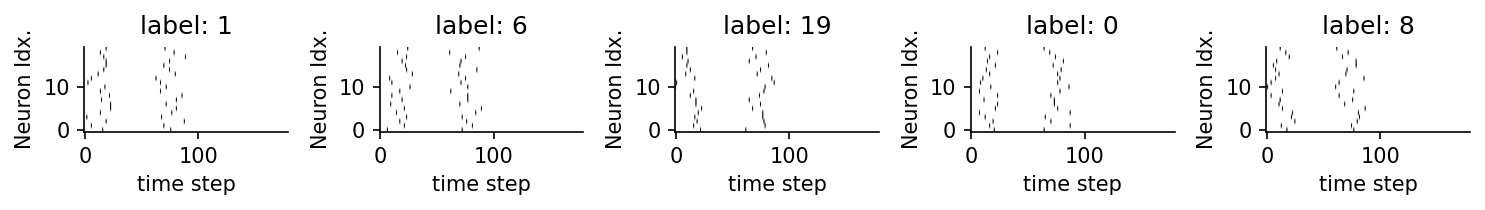

In [9]:
fig, ax = plt.subplots(1, 5, figsize=(10, 1.5), dpi=150)
for i in range(5):
    ax[i].imshow(np.transpose(ds_train[i][0]), cmap="binary", aspect="auto")
    ax[i].invert_yaxis()
    ax[i].set_xlabel("time step")
    ax[i].set_ylabel("Neuron Idx.")
    ax[i].set_title("label: " + str(ds_train[i][1]))

plt.tight_layout()
sns.despine()

## Set up the model

In [10]:
act_fn = stork.activations.CustomSpike
act_fn.escape_noise_type = "step"
act_fn.escape_noise_params = {"beta": beta}
act_fn.surrogate_type = "SuperSpike"
act_fn.surrogate_params = {"beta": beta}
neuron_group = FilterLIFGroup

model = RecurrentSpikingModel(batch_size, nb_time_steps, nb_inputs, device, dtype)

Add neuron groups

In [11]:
input_group = model.add_group(InputGroup(nb_inputs))
hidden_neurons = model.add_group(
    FilterLIFGroup(
        nb_hidden_units,
        nb_groups=nb_groups,
        tau_mem=tau_mem,
        tau_filter=tau_syn,
        activation=act_fn,
    )
)
readout_group = model.add_group(
    ReadoutGroup(nb_classes, tau_mem=tau_readout, tau_syn=tau_syn, initial_state=-1e-2)
)

Add synapses between the neuron groups

In [12]:
con = model.add_connection(Connection(input_group, hidden_neurons))
con_ro = model.add_connection(Connection(hidden_neurons, readout_group))

Add regularizers

In [13]:
# Define regularizer list
regs = []

regLB = LowerBoundL2(lowerBoundL2Strength, threshold=lowerBoundL2Threshold, dims=False)
regs.append(regLB)
regUB = UpperBoundL2(upperBoundL2Strength, threshold=upperBoundL2Threshold, dims=1)
regs.append(regUB)

# Add to neurons
hidden_neurons.regularizers.extend(regs)

We initialize the network in the Flucutation-Driven regime, with a target membrane potential standard deviation $\sigma_U=1.0$

In [14]:
initializer = KaimingNormalInitializer(gain=gain)

con.init_parameters(initializer=initializer)
con_ro.init_parameters(initializer=initializer)

Add monitors for spikes and membrane potential

In [15]:
model.add_monitor(PopulationFiringRateMonitor(model.groups[1]))

Choose loss function (We chose a maximum over time crossentropy loss, where the class is chosen according to the readout neuron that has the highest membrane potential over the simulation time)

In [16]:
loss_stack = SumOfSoftmaxCrossEntropy()

We select the SMORMS3 optimizer

In [17]:
opt = SMORMS3
generator = StandardGenerator(nb_workers=2)

In [18]:
model.configure(
    input=input_group,
    output=readout_group,
    loss_stack=loss_stack,
    generator=generator,
    optimizer=opt,
    optimizer_kwargs=dict(lr=lr),
    time_step=dt,
    wandb=wandbrun,
)

Before we train the model, we monitor the spikes

In [19]:
print(nb_inputs * nb_hidden_units)

4800


In [20]:
# Monitors spike counts before training
res = model.monitor(ds_test)

In [21]:
before_mean_pop_fr = torch.mean(res[0], dim=(0))


data = [
    [x, y]
    for (x, y) in zip(np.linspace(0, duration, nb_time_steps), before_mean_pop_fr)
]
table = wandb.Table(data=data, columns=["time", "before_mean_pop_fr"])
wandb.log(
    {
        "before_mean_pop_fr_plot": wandb.plot.line(
            table,
            "time",
            "before_mean_pop_fr",
            title="Mean Population Firing Rate (before training)",
        )
    }
)

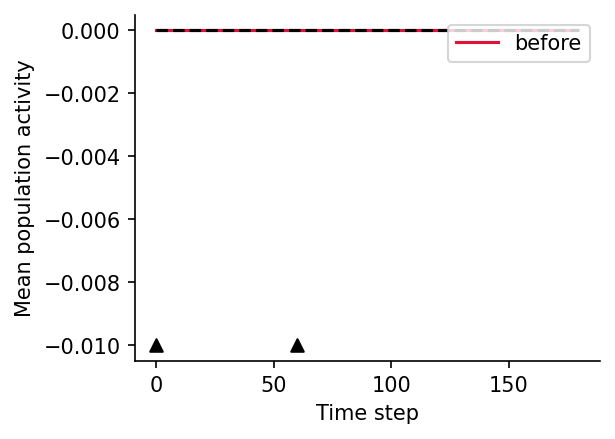

In [22]:
fig = plt.figure(figsize=(4, 3), dpi=150)
plt.plot(before_mean_pop_fr, color="crimson", label="before")

plt.hlines(0, 0, before_mean_pop_fr.shape[0], linestyle="--", color="black")


plt.scatter([0, sample_duration + T_delay], [-0.01, -0.01], color="black", marker="^")

plt.xlabel("Time step")
plt.ylabel("Mean population activity")
plt.legend(loc="upper right")
sns.despine()

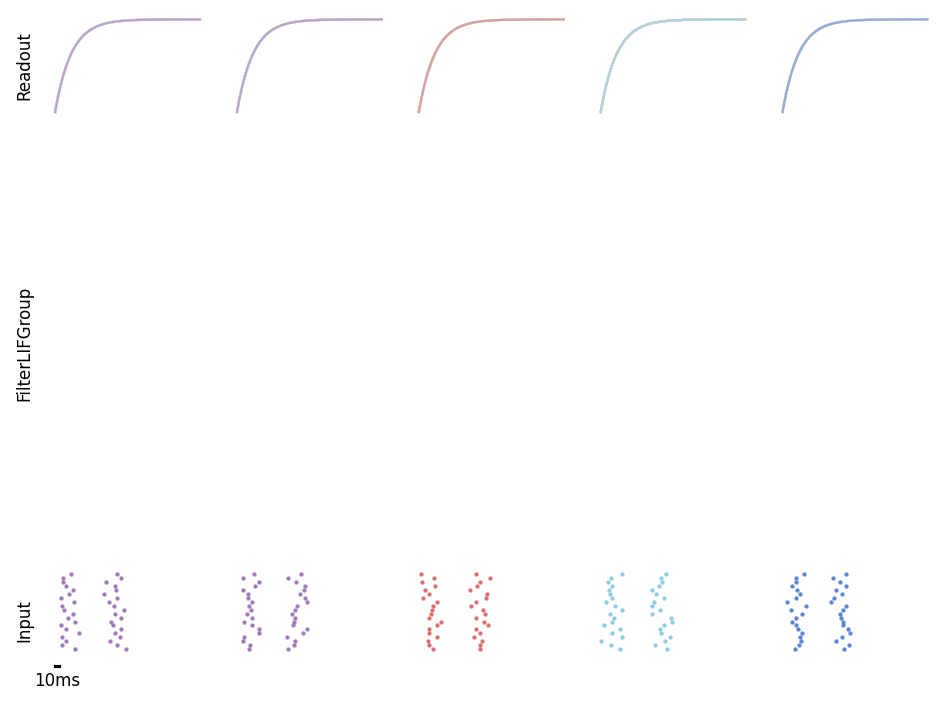

In [23]:
plt.figure(dpi=150)
stork.plotting.plot_activity_snapshot(
    model, data=ds_test, point_alpha=0.8, show_predictions=False
)

In [24]:
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
wandbrun.log({"nb_params": pytorch_total_params})
print(pytorch_total_params)

10840


## Training

takes around 13-20 minutes

In [25]:
results = {}

In [26]:
from tqdm import trange

for i in trange(1):
    history = model.fit_validate(
        ds_train, ds_valid, nb_epochs=nb_epochs, verbose=True, wandb=wandbrun
    )

  0%|          | 0/1 [00:00<?, ?it/s]

00  loss=1.75 reg_loss=2.64e-05 acc=0.494 -- val_loss=0.742 val_reg_loss=2.08e-05 val_acc=0.805 t_iter=182.02
01  loss=0.508 reg_loss=1.86e-05 acc=0.864 -- val_loss=0.374 val_reg_loss=1.64e-05 val_acc=0.901 t_iter=179.15
02  loss=0.323 reg_loss=1.43e-05 acc=0.909 -- val_loss=0.259 val_reg_loss=1.3e-05 val_acc=0.93 t_iter=170.30
03  loss=0.201 reg_loss=1.21e-05 acc=0.947 -- val_loss=0.161 val_reg_loss=1.16e-05 val_acc=0.959 t_iter=178.25
04  loss=0.137 reg_loss=1.11e-05 acc=0.966 -- val_loss=0.121 val_reg_loss=1.08e-05 val_acc=0.97 t_iter=174.62
05  loss=0.102 reg_loss=1.06e-05 acc=0.976 -- val_loss=0.0929 val_reg_loss=1.03e-05 val_acc=0.978 t_iter=181.38
06  loss=0.0789 reg_loss=1.01e-05 acc=0.982 -- val_loss=0.079 val_reg_loss=9.98e-06 val_acc=0.981 t_iter=177.83
07  loss=0.0652 reg_loss=9.75e-06 acc=0.985 -- val_loss=0.0626 val_reg_loss=9.59e-06 val_acc=0.985 t_iter=176.92
08  loss=0.0555 reg_loss=9.45e-06 acc=0.988 -- val_loss=0.0559 val_reg_loss=9.23e-06 val_acc=0.987 t_iter=179.18

In [27]:
results["train_loss"] = history["loss"].tolist()
results["train_acc"] = history["acc"].tolist()
results["valid_loss"] = history["val_loss"].tolist()
results["valid_acc"] = history["val_acc"].tolist()

#### Monitor the model again after training

In [28]:
res = model.monitor(ds_test)
total_spikes_per_layer = [torch.sum(res[i]).item() for i in range(1)]
results["avg_layer_freq"] = [
    nb / len(ds_test) / duration / nb_hidden_units for nb in total_spikes_per_layer
]

## Test

In [29]:
scores = model.evaluate(ds_test).tolist()
wandbrun.log({"test_loss": scores[0], "test_acc": scores[2]})
results["test_loss"] = scores[0]
results["test_acc"] = scores[2]

In [30]:
print("Test loss: ", scores[0])
print("Test acc.: ", round(scores[2] * 100, 2), "%")

Test loss:  2.1358542442321777
Test acc.:  20.0 %


In [31]:
print("Valid loss: ", history["val_loss"].tolist()[-1])
print("Valid acc.: ", round(history["val_acc"].tolist()[-1] * 100, 2), "%")

history.clear()

Valid loss:  2.1561787128448486
Valid acc.:  18.89 %


#### Monitor the model again after training


In [32]:
res = model.monitor(ds_test)

In [33]:
after_mean_pop_fr = torch.mean(res[0], dim=(0))


data = [
    [x, y] for (x, y) in zip(np.linspace(0, duration, nb_time_steps), after_mean_pop_fr)
]
table = wandb.Table(data=data, columns=["time", "after_mean_pop_fr"])
wandb.log(
    {
        "after_mean_pop_fr_plot": wandb.plot.line(
            table,
            "time",
            "after_mean_pop_fr",
            title="Mean Population Firing Rate (after training)",
        )
    }
)

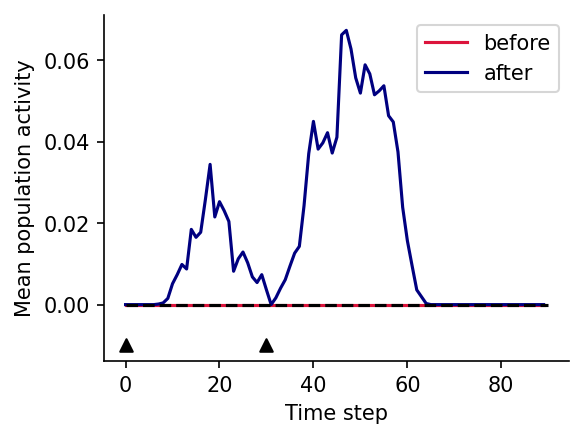

In [34]:
fig = plt.figure(figsize=(4, 3), dpi=150)
plt.plot(before_mean_pop_fr, color="crimson", label="before")
plt.plot(after_mean_pop_fr, color="navy", label="after")

plt.hlines(0, 0, after_mean_pop_fr.shape[0], linestyle="--", color="black")

plt.scatter([0, sample_duration + T_delay], [-0.01, -0.01], color="black", marker="^")

plt.xlabel("Time step")
plt.ylabel("Mean population activity")
plt.legend(loc="upper right")
sns.despine()

Test loss:  2.1358542442321777
Test acc.:  20.0 %


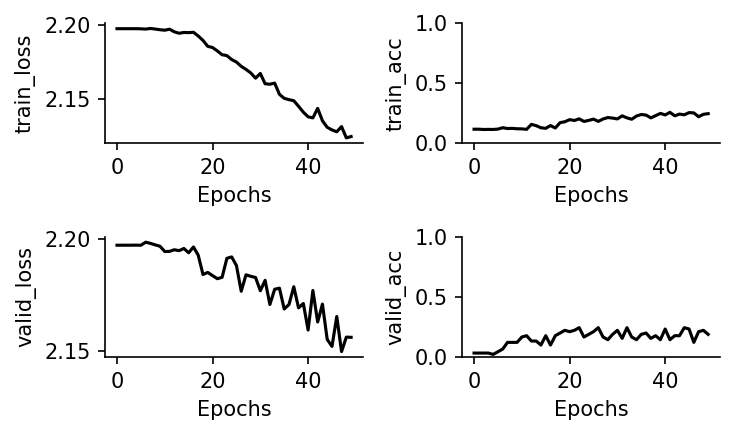

In [35]:
fig, ax = plt.subplots(2, 2, figsize=(5, 3), dpi=150)

for i, n in enumerate(["train_loss", "train_acc", "valid_loss", "valid_acc"]):

    if i < 2:
        a = ax[0][i]
    else:
        a = ax[1][i - 2]

    a.plot(results[n], color="black")
    a.set_xlabel("Epochs")
    a.set_ylabel(n)

ax[0, 1].set_ylim(0, 1)
ax[1, 1].set_ylim(0, 1)

sns.despine()
plt.tight_layout()

print("Test loss: ", results["test_loss"])
print("Test acc.: ", round(results["test_acc"] * 100, 2), "%")

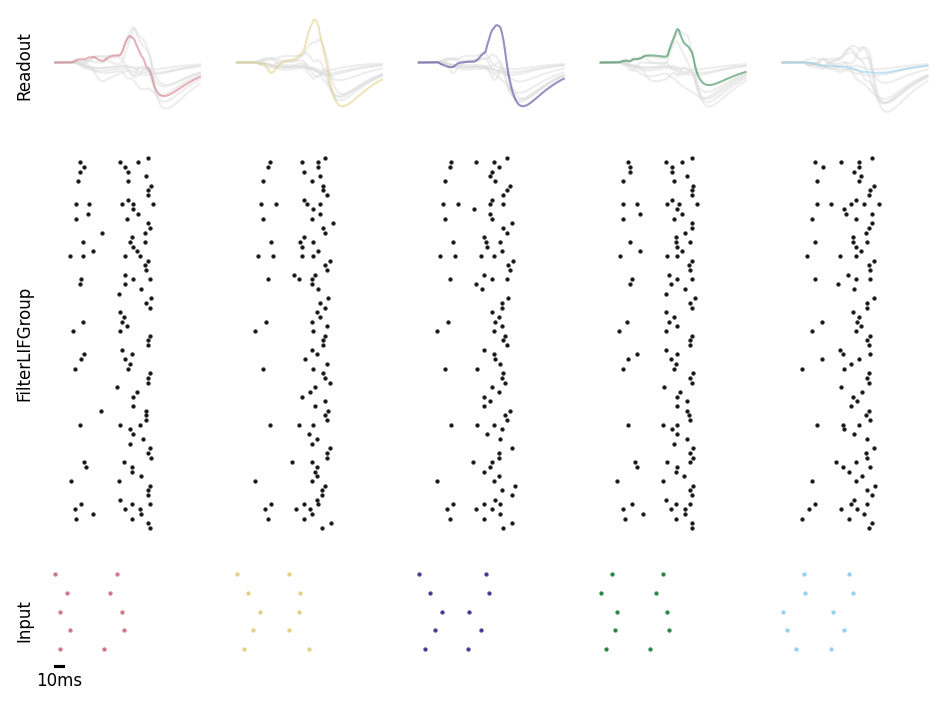

In [36]:
plt.figure(dpi=150)
stork.plotting.plot_activity_snapshot(
    model, data=ds_test, point_alpha=0.8, show_predictions=False, nb_samples=5
)

In [37]:
wandbrun.finish()

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


acc,▁▁▁▁▁▂▁▁▁▁▃▃▁▃▂▄▅▅▅▄▅▄▅▆▅▇▆▅▇▇▆▇▇█▇▇██▆▇
loss,███████████████▇▇▇▆▆▆▆▅▅▅▄▄▄▃▃▃▃▂▂▃▂▁▁▂▁
nb_params,▁
reg_loss,█████████▇▇▇▇▆▆▅▄▄▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
t_iter,█▆▇▃▅▅▄▄▄▇▅▇▆▇▆▄▃▃▅▁▄▃▃▆▃▅▇▄▂▄▇▅▄▂▃▄▂▃▂▅
test_acc,▁
test_loss,▁
val_acc,▁▁▁▁▁▂▄▄▅▆▄▄▆▃▆▇▇▇█▅▇█▅▅▇▅█▅▆▇▅▆█▅▆▆█▄▇▆
val_loss,████████▇▇█▇▇█▇▆▆▆▆▇▇▅▆▆▅▆▄▅▄▄▅▄▂▅▃▄▁▃▁▂
val_reg_loss,████████▇▇▇▇▆▆▅▅▄▄▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
acc,0.24655
